In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
import warnings

warnings.filterwarnings('ignore')

def load_and_clean_data():
    df_gold = pd.read_csv('Gold Price (2013-2023).csv')
    df_gold['Date'] = pd.to_datetime(df_gold['Date'])
    for col in ['Price', 'Open', 'High', 'Low']:
        df_gold[col] = df_gold[col].astype(str).str.replace(',', '').astype(float)
    df_gold = df_gold.sort_values('Date').set_index('Date')

    df_market = pd.read_csv('final_data.csv')
    df_market['Date'] = pd.to_datetime(df_market['Date'], dayfirst=True)
    for col in ['USO', 'SLV', 'S&P500', 'EUR/USD']:
        if df_market[col].dtype == 'object':
            df_market[col] = df_market[col].astype(str).str.replace(',', '').astype(float)
    df_market = df_market.sort_values('Date').set_index('Date')

    df_fed = pd.read_csv('FEDFUNDS.csv')
    df_fed['Date'] = pd.to_datetime(df_fed['observation_date'])
    df_fed = df_fed.set_index('Date')[['FEDFUNDS']]

    df_cpi = pd.read_csv('CORESTICKM159SFRBATL.csv')
    df_cpi['Date'] = pd.to_datetime(df_cpi['observation_date'])
    df_cpi = df_cpi.set_index('Date')[['CORESTICKM159SFRBATL']]
    
    return df_gold, df_market, df_fed, df_cpi

df_gold, df_market, df_fed, df_cpi = load_and_clean_data()

In [12]:
full_idx = pd.date_range(start=df_gold.index.min(), end=df_gold.index.max(), freq='D')
df_fed_daily = df_fed.reindex(full_idx, method='ffill')
df_cpi_daily = df_cpi.reindex(full_idx, method='ffill')

df = df_gold.join([df_market, df_fed_daily, df_cpi_daily], how='inner')
df['Real_Rate'] = df['FEDFUNDS'] - df['CORESTICKM159SFRBATL']

# Danh sách các cột cần dự báo biến động
cols_to_predict = ['Price', 'S&P500', 'SLV', 'USO', 'EUR/USD']
log_ret_cols = []

for col in cols_to_predict:
    name = f'{col}_LogRet'
    df[name] = np.log(df[col] / df[col].shift(1))
    log_ret_cols.append(name)

# Thêm Real_Rate vào danh sách features (nhưng không tính LogRet vì nó là lãi suất)
all_features = log_ret_cols + ['Real_Rate']

# TẠO TARGET ĐA MỤC TIÊU (Tất cả biến động của ngày mai)
target_cols = [f'Target_{c}' for c in all_features]
df[target_cols] = df[all_features].shift(-1)

df = df.dropna()

# 3. CHIA TRAIN/TEST
train_size = int(len(df) * 0.9)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

X_train = train[all_features]
y_train = train[target_cols] # Dự báo đồng thời cả Vàng, Bạc, Dầu, Chứng khoán, Lãi suất

# 4. HUẤN LUYỆN MODEL MULTI-OUTPUT
# Chúng ta dùng MultiOutputRegressor để XGBoost dự báo được nhiều cột một lúc
base_xgb = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42)
multi_model = MultiOutputRegressor(base_xgb)
multi_model.fit(X_train, y_train)

# 5. DỰ BÁO ĐỆ QUY TOÀN PHẦN (FULL RECURSIVE)
current_input = train[all_features].iloc[-1].copy()
last_actual_gold_price = train['Price'].iloc[-1]

recursive_gold_preds = []
actual_gold_prices = test['Price'].values

print("Starting Full Recursive Forecast for ALL features...")


Starting Full Recursive Forecast for ALL features...


In [ ]:
for i in range(len(test)):
    # Dự báo toàn bộ vector LogRet của ngày mai
    X_input = current_input.values.reshape(1, -1)
    preds_vector = multi_model.predict(X_input)[0]
    
    gold_log_ret_pred = preds_vector[0]

    predicted_gold_price = last_actual_gold_price * np.exp(gold_log_ret_pred)
    recursive_gold_preds.append(predicted_gold_price)
    
    current_input = pd.Series(preds_vector, index=all_features)
    
    last_actual_gold_price = predicted_gold_price

mape = mean_absolute_percentage_error(actual_gold_prices, recursive_gold_preds) * 100
print(f"\n[Full Recursive Market] Gold MAPE: {mape:.2f}%")


[Full Recursive Market] Gold MAPE: 12.22%


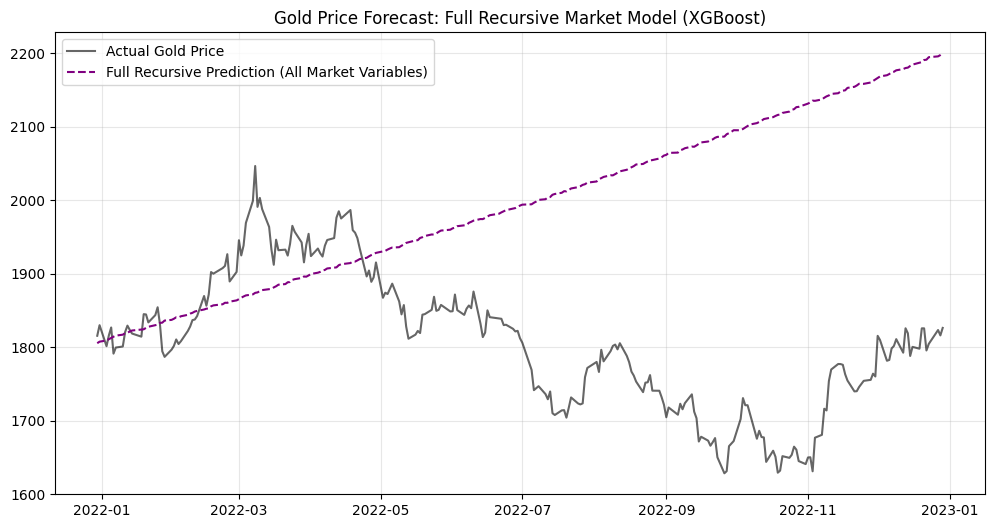

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, actual_gold_prices, label='Actual Gold Price', color='black', alpha=0.6)
plt.plot(test.index, recursive_gold_preds, label='Full Recursive Prediction (All Market Variables)', color='purple', linestyle='--')
plt.title("Gold Price Forecast: Full Recursive Market Model (XGBoost)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()